# Representational Similarity Analysis

Let's grab all necessary libraries.

In [9]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline

import seaborn as sns #a nice library for (“publication-ready“) visualization
import pandas as pd #a nice library for handling data frames
import numpy as np
import mne

from scipy.stats import spearmanr

import itertools
import matplotlib.pyplot as plt

## RSA Analysis - static

We will take the MEG data with presentation of the four pure tone frequencies (200, 431, 928 and 2000 Hz).

In [4]:
# This is identical to the last lecture
info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=100)

datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture3_Decoding/data/dataset4nathan.mat"
epochs = mne.read_epochs_fieldtrip(datapath, info)

epochs.event_id = {
                    "200Hz": 16,
                    "431Hz": 32,
                    "928Hz": 64,
                    "2000Hz": 128
                }

Adding metadata with 3 columns
2845 matching events found
No baseline correction applied


We have four frequencies, so in the end the RDMs will be a 4x4 matrix. The dissimilarity along the diagonal is 0 and the matrix is symmetric around the diagonal. So the dissimilarity needs to be only calculated once for each tone pair.

We will use decoding to assess the dissimilarity: The better the decoding score, the more “dissimilar“ the patterns likely are.

The following code builds an empty matrix to store the decoding results.

Further, it creates an array (*ones_indices*) in which each row stores which conditions should be entered for pairwise decoding.

In [122]:
# make empty rdm mat and prepare all combos of decoding

scoreMat = np.empty((4, 4))
scoreMat[:] = np.nan

# find combination of tone pairs in decoding 
vector = np.arange(0,4)
combinations = np.array(list(itertools.product([0, 1], repeat=len(vector))))

sums = np.sum(combinations, 1)
ind2 = np.where(sums == 2)[0]
combinations = combinations[ind2]

ones_indices = []
for row in combinations:
    ones_indices.append(np.where(row == 1)[0])

ones_indices = np.array(ones_indices)


Now we will perform a decoding analysis using the code from last lecture, with 2 critical differences.
1) We will perform pairwise decoding rather than entering all conditions at once. I.e. we will loop through *ones_indices* for that.
2) We will enter all time points at once! For this we will reshape the MEG data such that the columns contain the 71 time points!

In [123]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="balanced_accuracy", verbose=True)

for ii in range(len(ones_indices)):
    str0 = list(epochs.event_id)[ones_indices[ii,0]]
    str1 = list(epochs.event_id)[ones_indices[ii,1]]
    
    alldata = epochs[str0].get_data()
    alldata = np.concatenate((alldata, epochs[str1].get_data()), axis=0)
    
    labelvec = np.append(np.zeros(epochs[str0].get_data().shape[0]),
                            np.ones(epochs[str1].get_data().shape[0]))
    
    alldata = alldata.reshape(alldata.shape[0], alldata.shape[1]*alldata.shape[2],1) #maintain 3D array to “trick“ SlidingEstimator
    
    scores = cross_val_multiscore(time_decod, alldata, labelvec, cv=4, n_jobs=None)
    
    scoreMat[ones_indices[ii,1], ones_indices[ii,0]] = np.mean(scores)
    

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/1 [00:00<?,       ?it/s]

We can now plot the dissimilarity matrix based on the MEG data!

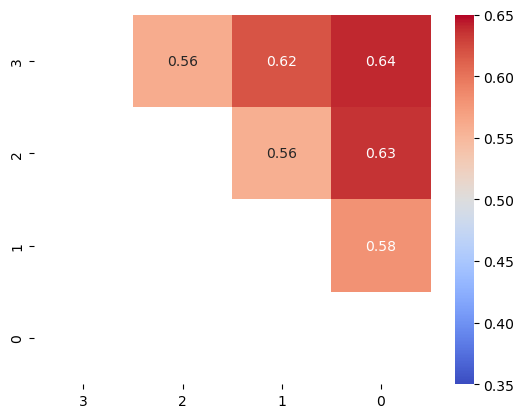

In [124]:
ax = sns.heatmap(scoreMat, cmap='coolwarm', annot=True, vmin = .35, vmax = .65)
ax.invert_yaxis()
ax.invert_xaxis()

plt.show()


Now let's make 2 “conceptual“ models to check which one is better represented by our neural data:
- the first model assumes that only the lowest two tones are differentiateted (mod0). This is “nonsensical“ for healthy, normal hearing individuals.
- the second model assumes sounds the differenation will be stronger the further the carrier frequencyies are apart (mod1)

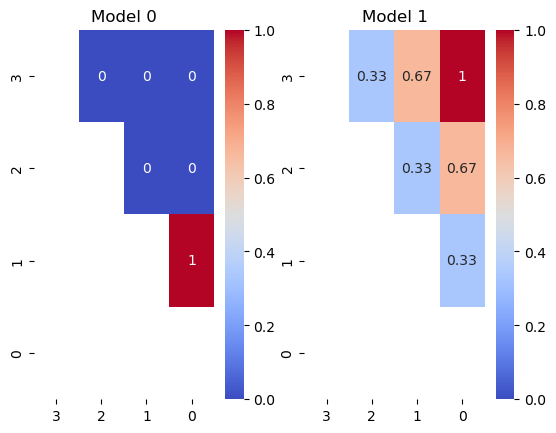

In [125]:
mod0 = np.tril(np.zeros((4,4)), -1)
mod0[np.triu_indices(4)] = np.nan
mod0[1,0] = 1 

cfvec = np.log10(np.array([200, 431, 928, 2000]))

mod1 = np.subtract.outer(cfvec, cfvec)
mod1 = np.abs(diffs)

mod1[np.triu_indices(4)] = np.nan


# Now plot

f, axes = plt.subplots(1, 2)
sns.heatmap(mod0, cmap='coolwarm', annot=True, vmin = 0, vmax = 1, ax = axes[0]).set(title = "Model 0")
axes[0].invert_yaxis()
axes[0].invert_xaxis()

sns.heatmap(mod1, cmap='coolwarm', annot=True, vmin = 0, vmax = 1, ax = axes[1]).set(title = "Model 1")
axes[1].invert_yaxis()
axes[1].invert_xaxis()
plt.show()



To quantify which conceptual model is closer to our MEG data, let's perform a Spearman Rank Correlation.

In [126]:
# get non-NaN values from mod0 and scoreMat
mod0_nonan = mod0[~np.isnan(scoreMat)]
mod1_nonan = mod1[~np.isnan(scoreMat)]

scoreMat_nonan = scoreMat[~np.isnan(scoreMat)] 

#we need to add a little variance to mod0 to make correlation calculation work
#mod0_nonan = mod0_nonan + np.random.uniform(low=-0.000000000000001, high=0.000000000000001, size=len(mod0_nonan)) 

# calculate spearman correlation
corr_mod0, pval = spearmanr(mod0_nonan, scoreMat_nonan)
corr_mod1, pval = spearmanr(mod1_nonan, scoreMat_nonan)


print("Spearman correlation between mod0 and scoreMat:", corr_mod0)
print("Spearman correlation between mod1 and scoreMat:", corr_mod1)


Spearman correlation between mod0 and scoreMat: -0.13093073414159545
Spearman correlation between mod1 and scoreMat: 0.8857142857142858


## RSA temporally resolved

The similarity value above is static, but we have also got time information. So what we need is to have the neural RDM calculated per sampling point and then calcute the correlations fpr each time point.

In [127]:
#empty mat
scoreMat = np.empty((4, 4, epochs[str0].get_data().shape[2]))
scoreMat[:] = np.nan

clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="balanced_accuracy", verbose=True)


for ii in range(len(ones_indices)):
    str0 = list(epochs.event_id)[ones_indices[ii,0]]
    str1 = list(epochs.event_id)[ones_indices[ii,1]]
    #print(str0, str1)
    alldata = epochs[str0].get_data()
    alldata = np.concatenate((alldata, epochs[str1].get_data()), axis=0)
        
    labelvec = np.append(np.zeros(epochs[str0].get_data().shape[0]),
                                np.ones(epochs[str1].get_data().shape[0]))
            
    scores = cross_val_multiscore(time_decod, alldata, labelvec, cv=4, n_jobs=None)
        
    scoreMat[ones_indices[ii,1], ones_indices[ii,0], ] = np.mean(scores, axis=0)

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/71 [00:00<?,       ?it/s]

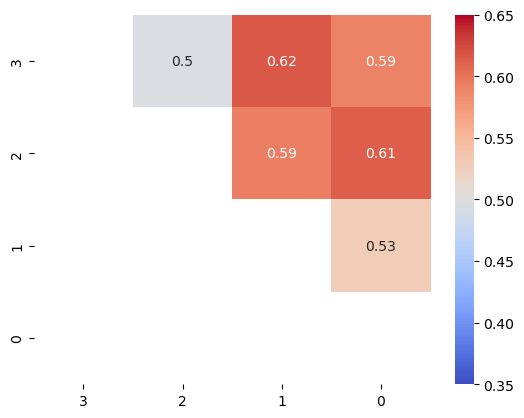

In [128]:
# some random RDM
ax = sns.heatmap(scoreMat[:,:,40], cmap='coolwarm', annot=True, vmin = .35, vmax = .65)
ax.invert_yaxis()
ax.invert_xaxis()

plt.show()

In [129]:
corrmod1_vec = []
corrmod0_vec = []
for i in range(scoreMat.shape[2]):
    scoreMat_nonan = scoreMat[:,:,i][~np.isnan(scoreMat[:,:,i])]
    mod1_nonan = mod1[~np.isnan(scoreMat[:,:,i])]
    corr, pval = spearmanr(mod1_nonan, scoreMat_nonan)
    corrmod1_vec.append(corr)
    
    mod0_nonan = mod0[~np.isnan(scoreMat[:,:,i])]
    corr, pval = spearmanr(mod0_nonan, scoreMat_nonan)
    corrmod0_vec.append(corr)
    

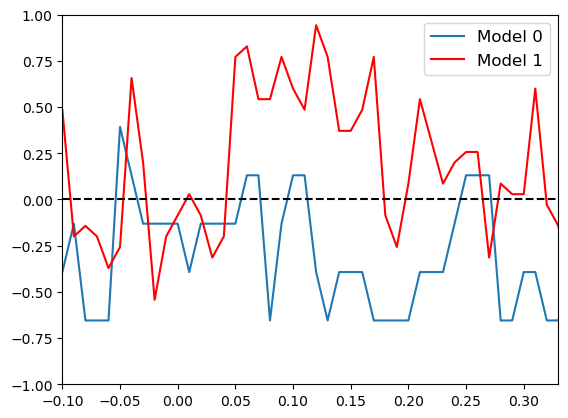

In [135]:
plt.plot(epochs.times, corrmod0_vec, label = 'Model 0')
plt.plot(epochs.times, corrmod1_vec, color = 'red', label = 'Model 1')
plt.ylim(-1, 1)
plt.xlim(-.1, .33)
plt.legend(fontsize=12)
plt.axhline(y=0, color='black', linestyle='--')


## Another example - from Andreas Wutz & Fabian Schmidt

This study builds on a work by our group ([Sanchez et al., 2020](https://www.pnas.org/doi/abs/10.1073/pnas.1912584117)) in which we implemented 3 near threshold experiments in the auditory, visual and somatosensory modality respectively, and used MEG to assess whether neural patterns indicating conscious perception can be generalized across sensory modalities.
![Design Sanchez](https://www.pnas.org/cms/10.1073/pnas.1912584117/asset/326a4978-40cc-4c03-9bdd-dff55b0b8399/assets/graphic/pnas.1912584117fig01.jpeg)

The using time- and condition-generalized decoding Sanchez et al. could show that ~>200ms a wide network of brain regions contain information on whether a stimulus is consciously perceived no matter which senors modality.
![Main Finding Sanchez](https://www.pnas.org/cms/10.1073/pnas.1912584117/asset/32a1719b-016a-4691-8ce0-22ff0e27522d/assets/graphic/pnas.1912584117fig05.jpeg)

In a current project a very similar experiment is implemented and will be used in MEG and fMRI. The goal is to merge both sources of data using RSA.

Here we use the RDMs provised by Fabian Schmidt and Andreas Wutz of their preliminary data.

In [168]:
supramoddata = np.load("/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture4_RSA/data/rsa4nathan.npy")
supramoddata.shape

(606, 276)

The data contains the RDMs 6 participants at 101 time points (100 Hz sampling starting at 0s). These are contained in the row of *supramoddata*. The colums are the actual RDM data (24 x 24 matrix), that have been flattened and in which the diagonal is 0. The original RDM is a 24 x 24 matrix, with 3 modalities (auditory, visual, somatosensory), 2 perceptual states (hits / miss), and 4 stimulus levels.

We will first, for the sake of ease average over all participants.

In [176]:
# split data so that subjects are in rows
supramoddata_split = supramoddata.reshape(-1, 101, supramoddata.shape[1])

# calculate the average across all subjects
supramoddata_avg = np.mean(supramoddata_split, axis=0)


(101, 276)


Let's have a function that plots the RDMs averaged over a selected time-slice.

In [197]:
def plot_fabi_RDM(supramoddata = supramoddata, starttime = 0, endtime = 1000):

    startsamp = int(np.round(starttime/10))
    endsamp =int(np.round(endtime/10))
    
    test = np.mean(supramoddata[startsamp:endsamp,:], axis = 0)

    # get shape of original matrix
    n = int(np.sqrt(2 * len(test))) + 1

    # get indices of upper triangular part
    tri_indices = np.triu_indices(n, k=1)

    # create 2D array of zeros
    matrix = np.zeros((n, n))

    # assign flattened array to upper triangular part
    matrix[tri_indices] = test

    # copy upper triangular part to lower triangular part
    matrix = matrix + matrix.T

    zlim = np.max(np.abs(matrix)) * .9
    ax = sns.heatmap(matrix, cmap='coolwarm', vmin = -zlim, vmax = zlim)
    ax.invert_yaxis()
    ax.invert_xaxis()

    plt.show()


Try a few time slices!

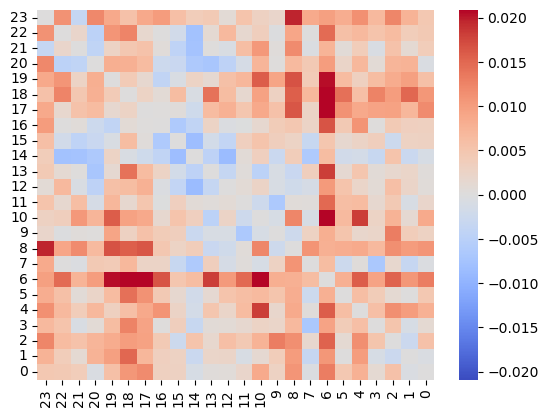

In [198]:
plot_fabi_RDM(starttime = 200, endtime = 300)

We will now create two conceptual models. One in which low-level processing within a modality is emphasized. Another in which conscious perception is emphasized.

In [287]:
#Modalities Auditory, Somatosensory, Visual
modality_vec = np.concatenate([np.zeros((1,8)), np.ones((1,8)), np.ones((1,8))*2])
modality_vec = modality_vec.flatten()

#Stimulus number ... 4 per modality sorted accourding to dissimilarity
stim_vec = np.tile(np.array(np.array(np.arange(1,5))).flatten(), 6)
#stim_vec = stim_vec.flatten()

#Behaviour: Hits and miss
perc_vec = np.tile(np.concatenate([np.zeros((1,4)), np.ones((1,4))]).flatten(), 3)

data = {'Modality': modality_vec,
        'Perceived': perc_vec,
        'Stimulus': stim_vec}

concept_df = pd.DataFrame(data)


In [365]:
ConsciousMat = np.zeros((len(concept_df), len(concept_df)))
SensoryMat = np.zeros((len(concept_df), len(concept_df)))

for ii in range(0,len(concept_df)):
    for kk in range(0,len(concept_df)):
        
        #make the supramodal model
        if concept_df["Perceived"].iloc[ii] == concept_df["Perceived"].iloc[kk]:
            ConsciousMat[ii, kk] = 0
        else:
            ConsciousMat[ii, kk] = 1
        
        #make the sensory model    
        if concept_df["Modality"].iloc[ii] == concept_df["Modality"].iloc[kk]:
            SensoryMat[ii, kk] = np.abs(concept_df["Stimulus"].iloc[ii] - concept_df["Stimulus"].iloc[kk]) / 4
        else:
            SensoryMat[ii, kk] = 1
        
SensoryMat = SensoryMat


We can now plot these models!

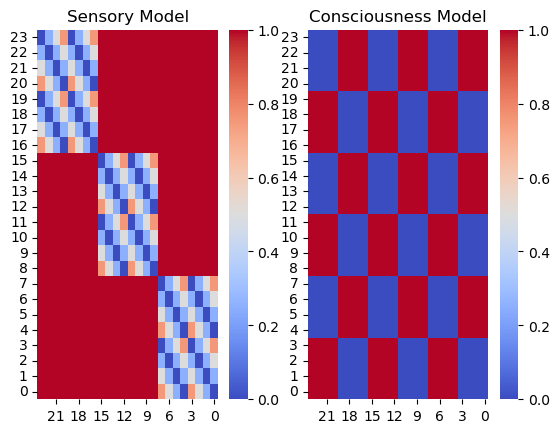

In [366]:
f, axes = plt.subplots(1, 2)
sns.heatmap(SensoryMat, cmap='coolwarm', vmin = 0, vmax = 1, ax = axes[0]).set(title = "Sensory Model")
axes[0].invert_yaxis()
axes[0].invert_xaxis()

sns.heatmap(ConsciousMat, cmap='coolwarm', vmin = 0, vmax = 1, ax = axes[1]).set(title = "Consciousness Model")
axes[1].invert_yaxis()
axes[1].invert_xaxis()
plt.show()

In [367]:
def get_corrs_fabi(supramoddata = supramoddata_avg, modelMat = SensoryMat):
    
    corr_vec = []
    tri_inds = np.triu_indices(modelMat.shape[0], k=1)
    
    for ii in range(0, supramoddata.shape[0]):
        corr, pval = spearmanr(supramoddata[ii,:], modelMat[tri_inds])
        corr_vec.append(corr)
    
    return corr_vec

In [368]:
sensory_RSA = get_corrs_fabi(modelMat = SensoryMat)
conscious_RSA = get_corrs_fabi(modelMat = ConsciousMat)

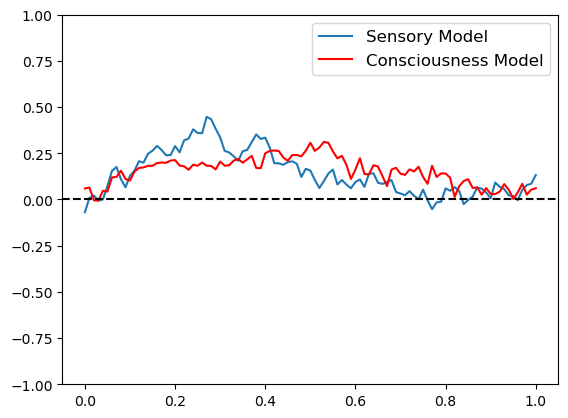

In [370]:
plt.plot(np.arange(0,len(sensory_RSA)) / 100, sensory_RSA, label = 'Sensory Model')
plt.plot(np.arange(0,len(conscious_RSA)) / 100, conscious_RSA , color = 'red', label = 'Consciousness Model')
plt.ylim(-1, 1)
#plt.xlim(-.1, .33)
plt.legend(fontsize=12)
plt.axhline(y=0, color='black', linestyle='--')